In [1]:
--******RUN-1 PARAMETERS*****--

---- Instead of 10-way classification its performs BINARY CLASSIFICATION over image pairs
require 'xlua'
require 'optim'
require 'nn'
require 'cunn'
model_utils = require 'model_utils'
dofile './provider.lua'
c = require 'trepl.colorize'
require 'image'
require 'csvigo'

cmd_params = {}
----- from the opt settings ------
cmd_params.save = 'logs_objdiscodata_trial/2_level_atten_1global_concatDP_cifar100'
cmd_params.batchSize = 128
cmd_params.learningRate = 1
cmd_params.learningRateDecay = 1e-7
cmd_params.weightDecay = 0.0005
cmd_params.momentum = 0.9
cmd_params.epochStep = 25

cmd_params.mlocal_1 = ''
cmd_params.mlocal_2 = ''
cmd_params.mglobal_2 = ''
cmd_params.matten_1 = ''
cmd_params.matten_2 = ''
cmd_params.mmatch = ''
----------------------------------
cmd_params.max_epoch = 300
cmd_params.backend = 'nn'
cmd_params.type = 'cuda'
----------------------------------
cmd_params.gpumode = 1
cmd_params.gpu_setDevice = 1


In [2]:
function cast(t)
   if cmd_params.type == 'cuda' then
      require 'cunn'
        gpumode = cmd_params.gpumode
        if gpumode==1 then
            cutorch.setDevice(cmd_params.gpu_setDevice)
        end
      return t:cuda()
   elseif cmd_params.type == 'float' then
      return t:float()
   elseif cmd_params.type == 'cl' then
      require 'clnn'
      return t:cl()
   else
      error('Unknown type '..cmd_params.type)
   end
end

In [3]:
local seed = 1234567890
torch.manualSeed(seed)
train_or_val = cmd_params.train_or_val

In [4]:
----Data Augmentation
function data_aug(input)
      local bs = input:size(1)
      local flip_mask = torch.randperm(bs):le(bs/2)
      for i=1,input:size(1) do
        if flip_mask[i] == 1 then image.hflip(input[i], input[i]) end
      end    
    return input
    
end

==> loading data	


{
  data : FloatTensor - size: 11x3x32x32
  size : function: 0x41d86678
  labels : DoubleTensor - size: 11x1
}


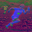

 1
[torch.DoubleTensor of size 1]



In [5]:
----Initiation
require 'nngraph'
--1. Data loading
print(c.blue '==>' ..' loading data')


--provider = torch.load './dataset/cifar100_whitened.t7'  ---sjmod
provider = torch.load './dataset/norms/person_bearperson_norm.t7'  ---sjmod
provider.trainData.data = provider.trainData.data:float()
provider.testData.data = provider.testData.data:float()
--[[
provider = torch.load './dataset/person_bearperson.t7'  ---sjmod
provider.testData = {}
provider.testData.data = provider.data:float()
provider.testData.labels = provider.label
--]]
print(provider.testData)
itorch.image(provider.testData.data[1]:squeeze())
print(provider.testData.labels[1])


In [6]:


-------------------------------------------------------------------------------------------------
--2. Model creation
mlocal1_wts = torch.load('./weights/2_level_atten_1global_concatDP_cifar10/mlocal_1.net')
mlocal_1 = nn.Sequential()
mlocal_1:add(cast(nn.Copy('torch.FloatTensor', torch.type(cast(torch.Tensor())))))
--mlocal_1:add(cast(dofile('models/'..cmd_params.mlocal_1..'.lua')))
mlocal_1:add(mlocal1_wts)
mlocal_1:get(1).updateGradInput = function(input) return end
if cmd_params.backend == 'cudnn' then
   require 'cudnn'
   cudnn.convert(mlocal_1:get(2), cudnn)
end

mlocal2_wts = torch.load('./weights/2_level_atten_1global_concatDP_cifar10/mlocal_2.net')
mlocal_2 = nn.Sequential()
--mlocal_2:add(cast(dofile('models/'..cmd_params.mlocal_2..'.lua')))
mlocal_2:add(mlocal2_wts)
if cmd_params.backend == 'cudnn' then
    cudnn.convert(mlocal_2:get(1), cudnn)
end

-----------------------------------------------------------------------------------------------
mglobal2_wts = torch.load('./weights/2_level_atten_1global_concatDP_cifar10/mglobal_2.net')
mglobal_2 = nn.Sequential()
--mglobal_3:add(cast(dofile('models/'..cmd_params.mglobal_3..'.lua')))
mglobal_2:add(mglobal2_wts)
if cmd_params.backend == 'cudnn' then
    cudnn.convert(mglobal_2:get(1), cudnn)
end
-------------------------------------------------------------------------------------------------

matten1_wts = torch.load('./weights/2_level_atten_1global_concatDP_cifar10/matten_1.net')
matten_1 = nn.Sequential()
--matten_1:add(cast(dofile('models/'..cmd_params.matten_1..'.lua')))
matten_1:add(matten1_wts)
if cmd_params.backend == 'cudnn' then
    cudnn.convert(matten_1:get(1),cudnn)
end

matten2_wts = torch.load('./weights/2_level_atten_1global_concatDP_cifar10/matten_2.net')
matten_2 = nn.Sequential()
--matten_2:add(cast(dofile('models/'..cmd_params.matten_2..'.lua')))
matten_2:add(matten2_wts)
if cmd_params.backend == 'cudnn' then
    cudnn.convert(matten_2:get(1),cudnn)
end

-------------------------------------------------------------------------------------------------

mmatch_wts = torch.load('./weights/2_level_atten_1global_concatDP_cifar10/mmatch.net')
mmatch = nn.Sequential()
--mmatch:add(cast(dofile('models/' ..cmd_params.mmatch..'.lua')))
mmatch:add(mmatch_wts)
if cmd_params.backend == 'cudnn' then
    cudnn.convert(mmatch:get(1), 'cudnn')
end


--3. Criterion
print(c.blue'==>' ..' setting criterion')
criterion = cast(nn.CrossEntropyCriterion())

--4. Testing and saving
confusion = optim.ConfusionMatrix(100)
print('Will save at '..cmd_params.save)
paths.mkdir(cmd_params.save)
testLogger = optim.Logger(paths.concat(cmd_params.save, 'test.log'))
testLogger:setNames{'% mean class accuracy (train set)', '% mean class accuracy (test set)'}
testLogger.showPlot = false

-------------------------------------------------------------------------------------------------

--5. Learning settings
print(c.blue'==>' ..' configuring optimizer')
optimState = {
  learningRate = cmd_params.learningRate,
  weightDecay = cmd_params.weightDecay,
  momentum = cmd_params.momentum,
  learningRateDecay = cmd_params.learningRateDecay,
}

==> setting criterion	
Will save at logs_objdiscodata_trial/2_level_atten_1global_concatDP_cifar100	


==> configuring optimizer	


In [7]:
--test_unnorm = torch.load('/home/torrvision/zbs-torch/projects/cifar.torch/cifar100-test.t7')

In [8]:
function test()
  -- disable flips, dropouts and batch normalization
    mlocal_1:evaluate()
    mlocal_2:evaluate()   
    mglobal_2:evaluate()    
    matten_1:evaluate() 
    matten_2:evaluate()    
    mmatch:evaluate()

  -- Get the GLOBAL FEATURE from the TEMPLATE (first image in the testset)
    local l1 = mlocal_1:forward(provider.testData.data:narrow(1,1,1))           
    itorch.image(provider.testData.data:narrow(1,1,1))
    local l2 = mlocal_2:forward(l1)           
    local g = mglobal_2:forward(l2)
    -- clone the global vector --
    local gmain = g:clone()
    --print(gmain:sub(1,5))
    --print(gmain:size()) 
    
  -- Set up the TEST-BENCH and run it for CO-SEG
    print(c.blue '==>'.." testing")
    local bs = 1
    local nsamples = 11 --provider.testData.data:size(1)
    --fv_output = torch.zeros(nsamples,1280)
    
 for i=2,nsamples,bs do 
    local lfeat_1 = mlocal_1:forward(provider.testData.data:narrow(1,i,bs)) 
    local lfeat_2 = mlocal_2:forward(lfeat_1)           
    
    local gmain_re   =   mglobal_2:forward(lfeat_2)        
    
    local att_con_1 = matten_1:forward({lfeat_1,gmain}) -- ensure the use of gmain
    local att_con_2 = matten_2:forward({lfeat_2,gmain}) -- ensure the use of gmain
    
    itorch.image(provider.testData.data:narrow(1,i,bs))
    --print(gmain[1])print(gmain[2])print(gmain[3])print(gmain[4])print(gmain[5])  
    --print(lfeat_1[1][1][1])
    --print(gmain_re:sub(1,5))
    --print(gmain_re:size())
    print((gmain-gmain_re):sub(1,5))
    --print(provider.testData.labels:narrow(1,i,bs))

------------1. Visualizations
    --itorch.image(image.scale(att_con_1[1],64,64))
    --itorch.image(image.scale(att_con_2[1],64,64))        
    csvigo.save(string.format('%s/%03d_%s',cmd_params.save,i,'1.txt'),att_con_1[1]:squeeze():double():totable())
    csvigo.save(string.format('%s/%03d_%s',cmd_params.save,i,'2.txt'),att_con_2[1]:squeeze():double():totable())
    --image.save(string.format('%s/%03d_%s',cmd_params.save,i,'1.png'),att_con_1[1]:float())
    --image.save(string.format('%s/%03d_%s',cmd_params.save,i,'2.png'),att_con_2[1]:float())
--------------
    local prediction = mmatch:forward({att_con_1[2], att_con_2[2]})                                      
------------3. extract the feature vector
       --fv_output[i]=(mmatch:get(1).modules[13].output:squeeze():float())
------------4. No confusion analysis for labels > 10
    confusion:batchAdd(prediction, provider.testData.labels:narrow(1,i,bs))
    confusion:updateValids()
        
-----------2. Analysing the wrong and right predictions
    --[[
    print(provider.testData.labels:narrow(1,i,bs))
    if confusion.totalValid==0 then
        itorch.image(testData:narrow(1,i,bs))
        print(i)
    end
    print('Test accuracy:', confusion.totalValid * 100)
    confusion:zero()
    --]]
------------
        
  end
    --fv_output = fv_output:totable()
    --csvigo.save('logs_objdiscodata/vggstanfordaction40_atten3_fv.txt',fv_output)
    print('Test accuracy:', confusion.totalValid * 100)
    confusion:zero()
end

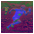

==> testing	


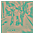

 0.0582
-0.0026
-0.3008
-0.0206
-0.0148
[torch.CudaTensor of size 5]

<csv>	writing to file: logs_objdiscodata_trial/2_level_atten_1global_concatDP_cifar100/002_1.txt	


<csv>	writing done	
<csv>	writing to file: logs_objdiscodata_trial/2_level_atten_1global_concatDP_cifar100/002_2.txt	
<csv>	writing done	


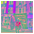

 0.0312
-0.0013
-0.1611
-0.0110
-0.0079
[torch.CudaTensor of size 5]

<csv>	writing to file: logs_objdiscodata_trial/2_level_atten_1global_concatDP_cifar100/003_1.txt	


<csv>	writing done	
<csv>	writing to file: logs_objdiscodata_trial/2_level_atten_1global_concatDP_cifar100/003_2.txt	
<csv>	writing done	


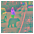

 0.0282
-0.0013
-0.1460
-0.0100
-0.0072
[torch.CudaTensor of size 5]

<csv>	writing to file: logs_objdiscodata_trial/2_level_atten_1global_concatDP_cifar100/004_1.txt	


<csv>	writing done	


<csv>	writing to file: logs_objdiscodata_trial/2_level_atten_1global_concatDP_cifar100/004_2.txt	


<csv>	writing done	


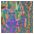

 0.0376
-0.0016
-0.1944
-0.0135
-0.0098
[torch.CudaTensor of size 5]

<csv>	writing to file: logs_objdiscodata_trial/2_level_atten_1global_concatDP_cifar100/005_1.txt	


<csv>	writing done	
<csv>	writing to file: logs_objdiscodata_trial/2_level_atten_1global_concatDP_cifar100/005_2.txt	
<csv>	writing done	


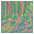

 0.0488
-0.0021
-0.2526
-0.0171
-0.0123
[torch.CudaTensor of size 5]

<csv>	writing to file: logs_objdiscodata_trial/2_level_atten_1global_concatDP_cifar100/006_1.txt	


<csv>	writing done	
<csv>	writing to file: logs_objdiscodata_trial/2_level_atten_1global_concatDP_cifar100/006_2.txt	
<csv>	writing done	


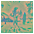

0.01 *
-0.9471
 0.0454
 4.8985
 0.3943
 0.2860
[torch.CudaTensor of size 5]

<csv>	writing to file: logs_objdiscodata_trial/2_level_atten_1global_concatDP_cifar100/007_1.txt	


<csv>	writing done	
<csv>	writing to file: logs_objdiscodata_trial/2_level_atten_1global_concatDP_cifar100/007_2.txt	
<csv>	writing done	


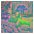

 0.0422
-0.0019
-0.2189
-0.0150
-0.0109
[torch.CudaTensor of size 5]

<csv>	writing to file: logs_objdiscodata_trial/2_level_atten_1global_concatDP_cifar100/008_1.txt	


<csv>	writing done	
<csv>	writing to file: logs_objdiscodata_trial/2_level_atten_1global_concatDP_cifar100/008_2.txt	
<csv>	writing done	


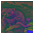

0.01 *
-1.8834
 0.0935
 9.7023
 0.7164
 0.5115
[torch.CudaTensor of size 5]

<csv>	writing to file: logs_objdiscodata_trial/2_level_atten_1global_concatDP_cifar100/009_1.txt	


<csv>	writing done	
<csv>	writing to file: logs_objdiscodata_trial/2_level_atten_1global_concatDP_cifar100/009_2.txt	
<csv>	writing done	


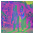

0.01 *
 0.9100
-0.0351
-4.7224
-0.2887
-0.2093
[torch.CudaTensor of size 5]

<csv>	writing to file: logs_objdiscodata_trial/2_level_atten_1global_concatDP_cifar100/010_1.txt	


<csv>	writing done	
<csv>	writing to file: logs_objdiscodata_trial/2_level_atten_1global_concatDP_cifar100/010_2.txt	
<csv>	writing done	


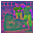

 0.0453
-0.0020
-0.2350
-0.0164
-0.0119
[torch.CudaTensor of size 5]

<csv>	writing to file: logs_objdiscodata_trial/2_level_atten_1global_concatDP_cifar100/011_1.txt	


<csv>	writing done	
<csv>	writing to file: logs_objdiscodata_trial/2_level_atten_1global_concatDP_cifar100/011_2.txt	
<csv>	writing done	


Test accuracy:	10	


In [9]:
for i=1,1 do --cmd_params.max_epoch do
  test()
end
